# User Preference Model Benchmarking (Binary)

This notebook builds an end-to-end **preprocessing + model benchmarking** pipeline for predicting `Event_Preference` from user profile data.

## What it does
1. **Loads** a synthetic dataset (`learning_data/user_data_examples_synthetic.csv`).
2. **Defines the target** as a binary label:
   - `Entertainment = 1` (positive class, used for ROC/PR curves by convention)
   - `Educational = 0`
3. **Preprocesses features** with a `ColumnTransformer`:
   - `Country_of_Origin` → continent code (custom transformer)
   - `Hobbies` → multi-hot binary columns (custom transformer)
   - numeric scaling for `Age` and `Income`
   - ordinal encoding for ordered categories (`Education`, `City_Size`)
   - one-hot encoding for nominal categories (`Gender`, `Marital_Status`, `Personality_Type`, `Occupation`)
4. Runs **GridSearchCV (cv=5)** for multiple models (LogReg, RF, SVM, Ridge, DT, GB, *optional* XGBoost).
5. Prints:
   - **Accuracy**, **Balanced Accuracy**, **MCC**
   - **Classification report** (precision/recall/F1 per class)
   - **Confusion matrix**
   - **ROC-AUC** and **PR-AUC (Average Precision)** and plots ROC / PR curves
   - simple **threshold tests** (0.3/0.5/0.7) for probability-based models
6. Exports the processed feature matrix to: `learning_data/processed_user_data.csv`.

> **Note on “positive class”**  
> ROC-AUC and PR-AUC require choosing a positive class by definition. Here `Entertainment=1` is chosen **only as a convention**; both classes are treated as equally important overall.


## Metrics explained (with formulas)

Let the confusion matrix terms be:

- **TP**: true positives (predict 1, true 1)  
- **TN**: true negatives (predict 0, true 0)  
- **FP**: false positives (predict 1, true 0)  
- **FN**: false negatives (predict 0, true 1)

### Accuracy
Overall fraction of correct predictions:

$$
\text{Accuracy}=\frac{TP+TN}{TP+TN+FP+FN}
$$

### Precision (for class 1)
Of the predicted positives, how many are correct:

$$
\text{Precision}=\frac{TP}{TP+FP}
$$

### Recall / Sensitivity / TPR (for class 1)
Of the actual positives, how many are found:

$$
\text{Recall}=\frac{TP}{TP+FN}
$$

### F1-score (for class 1)
Harmonic mean of precision and recall:

$$
F_1 = \frac{2\cdot \text{Precision}\cdot \text{Recall}}{\text{Precision}+\text{Recall}}
$$

### Balanced Accuracy
Average of recall for both classes (helps when classes are imbalanced):

$$
\text{Balanced\ Acc}=\frac{TPR+TNR}{2}
$$

where

$$
TPR=\frac{TP}{TP+FN},\quad TNR=\frac{TN}{TN+FP}
$$

### MCC (Matthews Correlation Coefficient)
A robust “single-number” score for binary classification (good even with imbalance):

$$
\text{MCC}=\frac{TP\cdot TN - FP\cdot FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}
$$

Ranges from **-1** (total disagreement) through **0** (random) to **+1** (perfect).

### ROC curve and ROC-AUC
- ROC curve plots **TPR vs FPR** as you vary the decision threshold.

$$
FPR=\frac{FP}{FP+TN}
$$

- **ROC-AUC** is the area under the ROC curve (threshold-independent ranking quality):

$$
\text{AUC}=\int_0^1 TPR(FPR)\, d(FPR)
$$

### Precision–Recall curve and PR-AUC (Average Precision)
- PR curve plots **Precision vs Recall** as the threshold changes.
- **Average Precision (AP)** summarizes the PR curve:

$$
AP=\sum_{n} (R_n - R_{n-1})\, P_n
$$

where $P_n$ and $R_n$ are precision and recall at threshold step $n$.

**Rule of thumb**
- Use **ROC-AUC** when you care about general separability/ranking.
- Use **PR-AUC (AP)** when the positive class is rare or you care more about performance on positives.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry_convert as pc

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    matthews_corrcoef,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)

# Optional: XGBoost
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False
    print("NOTE: xgboost is not installed. XGBoost will be skipped.")


In [2]:
# Load data
data = pd.read_csv("learning_data/user_data_examples_synthetic.csv")

# Target: Entertainment=1, Educational=0
y = (data["Event_Preference"] == "Entertainment").astype(int)

# Features
X = data.drop(columns=["Event_Preference"])

LABELS = ["Educational (0)", "Entertainment (1)"]

print("Rows:", len(data))
print("Class balance (Entertainment=1):")
print(y.value_counts(normalize=True))


Rows: 5000
Class balance (Entertainment=1):
Event_Preference
0    0.5152
1    0.4848
Name: proportion, dtype: float64


In [3]:
# --- Custom continent encoder ---
class ContinentEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return (
            X["Country_of_Origin"]
            .apply(lambda country: self.get_continent_code(country))
            .values.reshape(-1, 1)
        )

    def get_continent_code(self, country):
        continent_map = {
            "AF": 0, "AS": 1, "EU": 2, "NA": 3, "OC": 4, "SA": 5,
            "Unknown": -1
        }
        try:
            country_code = pc.country_name_to_country_alpha2(country)
            continent_code = pc.country_alpha2_to_continent_code(country_code)
            return continent_map.get(continent_code, -1)
        except Exception:
            return -1

    def get_feature_names_out(self, input_features=None):
        return ["Continent_Code"]


# --- Custom hobbies encoder (multi-hot) ---
class HobbyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, hobby_list):
        self.hobby_list = hobby_list

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = pd.DataFrame(X, columns=["Hobbies"])
        df["Hobbies"] = df["Hobbies"].fillna("").astype(str)

        for hobby in self.hobby_list:
            df[hobby] = df["Hobbies"].apply(lambda x: 1 if hobby in x else 0)
        return df[self.hobby_list].values

    def get_feature_names_out(self, input_features=None):
        return np.array(self.hobby_list)


In [4]:
# Column groups
hobby_cols = [
    "Sports", "Music", "Cooking", "Traveling", "Reading",
    "Gaming", "Art", "Photography", "Dancing", "Gardening"
]

numeric_cols = ["Age", "Income"]
binary_col = ["Children"]

# Nominal -> OneHot
one_hot_cols = ["Gender", "Marital_Status", "Personality_Type", "Occupation"]

# Ordinal -> OrdinalEncoder with explicit order
ordinal_cols = ["Education", "City_Size"]
education_order = ["Primary", "Secondary", "Bachelor", "Master", "PhD"]
city_size_order = ["Small", "Medium", "Large"]

preprocessor = ColumnTransformer(
    transformers=[
        ("continent", ContinentEncoder(), ["Country_of_Origin"]),
        ("hobbies", HobbyEncoder(hobby_cols), ["Hobbies"]),
        ("scaler", StandardScaler(), numeric_cols),
        ("binary", OrdinalEncoder(categories=[["No", "Yes"]]), binary_col),
        ("ordinal", OrdinalEncoder(categories=[education_order, city_size_order]), ordinal_cols),
        ("one_hot", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), one_hot_cols),
    ],
    remainder="drop"
)

# Fit + transform full X (for feature names + export)
X_processed = preprocessor.fit_transform(X)
feature_names = preprocessor.get_feature_names_out()

print("Processed shape:", X_processed.shape)
print("First 20 features:", feature_names[:20])

# Export processed features
processed_df = pd.DataFrame(X_processed, columns=feature_names)
processed_df.to_csv("learning_data/processed_user_data.csv", index=False)
print("Saved: learning_data/processed_user_data.csv")


Processed shape: (5000, 36)
First 20 features: ['continent__Continent_Code' 'hobbies__Sports' 'hobbies__Music'
 'hobbies__Cooking' 'hobbies__Traveling' 'hobbies__Reading'
 'hobbies__Gaming' 'hobbies__Art' 'hobbies__Photography'
 'hobbies__Dancing' 'hobbies__Gardening' 'scaler__Age' 'scaler__Income'
 'binary__Children' 'ordinal__Education' 'ordinal__City_Size'
 'one_hot__Gender_Female' 'one_hot__Gender_Male'
 'one_hot__Marital_Status_Divorced' 'one_hot__Marital_Status_Married']
Saved: learning_data/processed_user_data.csv



=== Training model: Logistic Regression ===
Best params: {'C': 0.1, 'solver': 'liblinear'}
Accuracy: 0.8680 | Balanced Acc: 0.8676 | MCC: 0.7357
                   precision    recall  f1-score   support

  Educational (0)       0.87      0.88      0.87       773
Entertainment (1)       0.87      0.86      0.86       727

         accuracy                           0.87      1500
        macro avg       0.87      0.87      0.87      1500
     weighted avg       0.87      0.87      0.87      1500



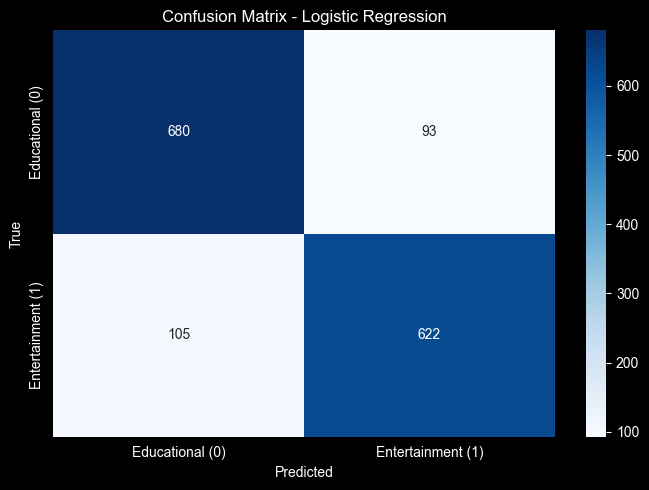

ROC-AUC (pos=Entertainment=1): 0.9517
PR-AUC / AP (pos=Entertainment=1): 0.9497
Threshold tuning (probability models):
  thr=0.30 -> precision=0.773, recall=0.953, f1=0.854
  thr=0.50 -> precision=0.870, recall=0.856, f1=0.863
  thr=0.70 -> precision=0.954, recall=0.714, f1=0.817

=== Training model: Random Forest ===
Best params: {'max_depth': 20, 'n_estimators': 200}
Accuracy: 0.8873 | Balanced Acc: 0.8866 | MCC: 0.7748
                   precision    recall  f1-score   support

  Educational (0)       0.88      0.91      0.89       773
Entertainment (1)       0.90      0.86      0.88       727

         accuracy                           0.89      1500
        macro avg       0.89      0.89      0.89      1500
     weighted avg       0.89      0.89      0.89      1500



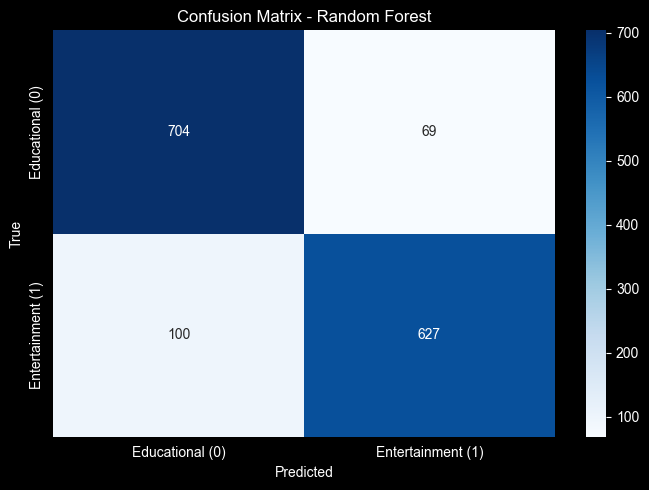

ROC-AUC (pos=Entertainment=1): 0.9576
PR-AUC / AP (pos=Entertainment=1): 0.9573
Threshold tuning (probability models):
  thr=0.30 -> precision=0.783, recall=0.957, f1=0.861
  thr=0.50 -> precision=0.896, recall=0.862, f1=0.879
  thr=0.70 -> precision=0.966, recall=0.707, f1=0.817

=== Training model: SVM ===
Best params: {'C': 1, 'kernel': 'rbf'}
Accuracy: 0.8753 | Balanced Acc: 0.8748 | MCC: 0.7505
                   precision    recall  f1-score   support

  Educational (0)       0.87      0.89      0.88       773
Entertainment (1)       0.88      0.86      0.87       727

         accuracy                           0.88      1500
        macro avg       0.88      0.87      0.88      1500
     weighted avg       0.88      0.88      0.88      1500



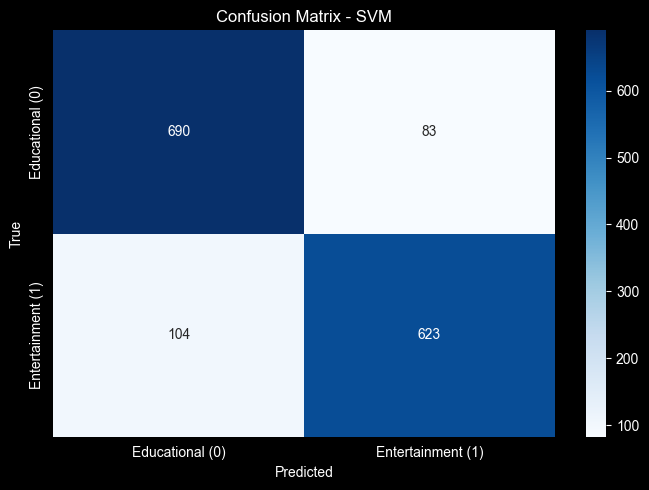

ROC-AUC (pos=Entertainment=1): 0.9562
PR-AUC / AP (pos=Entertainment=1): 0.9569
Threshold tuning (probability models):
  thr=0.30 -> precision=0.819, recall=0.922, f1=0.867
  thr=0.50 -> precision=0.875, recall=0.869, f1=0.872
  thr=0.70 -> precision=0.928, recall=0.796, f1=0.857

=== Training model: Ridge Classifier ===
Best params: {'alpha': 10}
Accuracy: 0.8693 | Balanced Acc: 0.8692 | MCC: 0.7384
                   precision    recall  f1-score   support

  Educational (0)       0.87      0.87      0.87       773
Entertainment (1)       0.87      0.86      0.87       727

         accuracy                           0.87      1500
        macro avg       0.87      0.87      0.87      1500
     weighted avg       0.87      0.87      0.87      1500



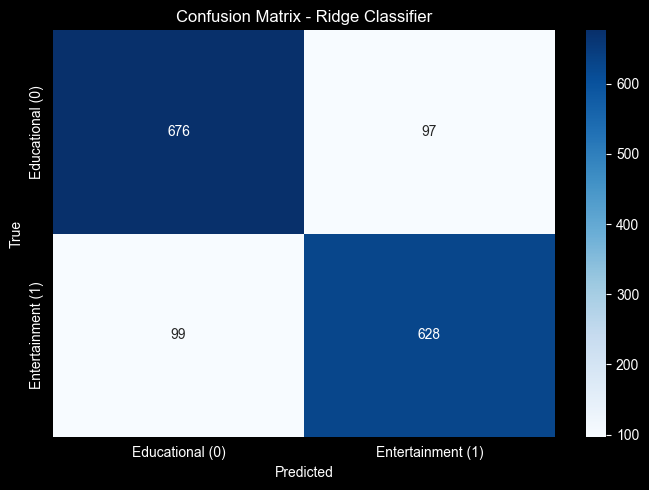

ROC-AUC (pos=Entertainment=1): 0.9512
PR-AUC / AP (pos=Entertainment=1): 0.9494

=== Training model: Decision Tree ===
Best params: {'criterion': 'gini', 'max_depth': 5}
Accuracy: 0.8680 | Balanced Acc: 0.8662 | MCC: 0.7393
                   precision    recall  f1-score   support

  Educational (0)       0.84      0.92      0.88       773
Entertainment (1)       0.91      0.81      0.86       727

         accuracy                           0.87      1500
        macro avg       0.87      0.87      0.87      1500
     weighted avg       0.87      0.87      0.87      1500



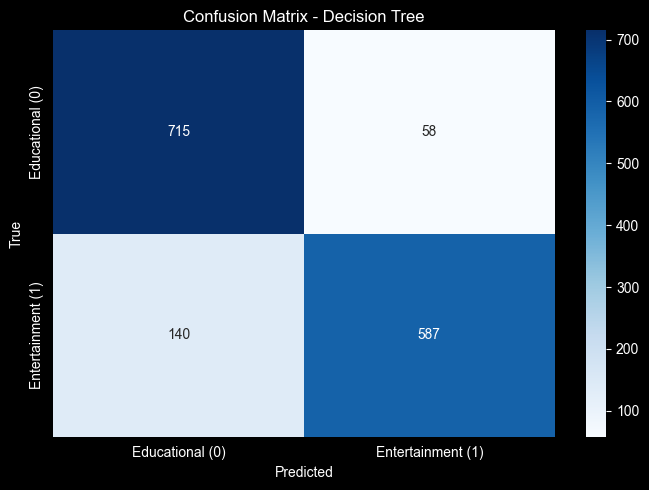

ROC-AUC (pos=Entertainment=1): 0.9390
PR-AUC / AP (pos=Entertainment=1): 0.9231
Threshold tuning (probability models):
  thr=0.30 -> precision=0.752, recall=0.939, f1=0.835
  thr=0.50 -> precision=0.909, recall=0.812, f1=0.858
  thr=0.70 -> precision=0.931, recall=0.794, f1=0.857

=== Training model: Gradient Boosting ===
Best params: {'learning_rate': 0.1, 'n_estimators': 100}
Accuracy: 0.8960 | Balanced Acc: 0.8955 | MCC: 0.7919
                   precision    recall  f1-score   support

  Educational (0)       0.89      0.91      0.90       773
Entertainment (1)       0.90      0.88      0.89       727

         accuracy                           0.90      1500
        macro avg       0.90      0.90      0.90      1500
     weighted avg       0.90      0.90      0.90      1500



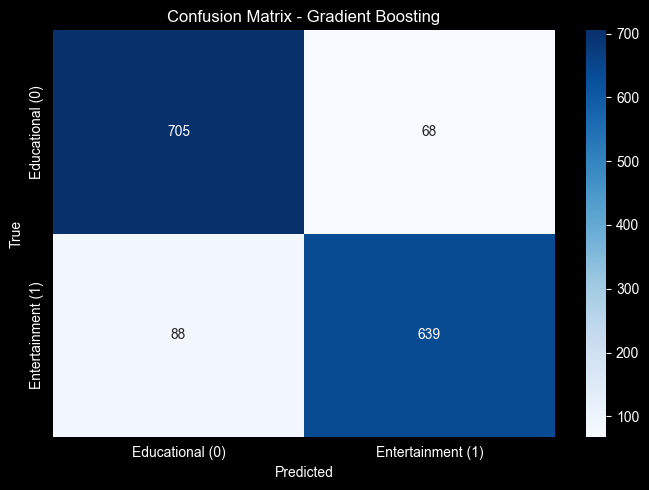

ROC-AUC (pos=Entertainment=1): 0.9648
PR-AUC / AP (pos=Entertainment=1): 0.9646
Threshold tuning (probability models):
  thr=0.30 -> precision=0.822, recall=0.952, f1=0.882
  thr=0.50 -> precision=0.904, recall=0.879, f1=0.891
  thr=0.70 -> precision=0.960, recall=0.754, f1=0.844

=== Training model: XGBoost ===
Best params: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
Accuracy: 0.8933 | Balanced Acc: 0.8929 | MCC: 0.7865
                   precision    recall  f1-score   support

  Educational (0)       0.89      0.91      0.90       773
Entertainment (1)       0.90      0.88      0.89       727

         accuracy                           0.89      1500
        macro avg       0.89      0.89      0.89      1500
     weighted avg       0.89      0.89      0.89      1500



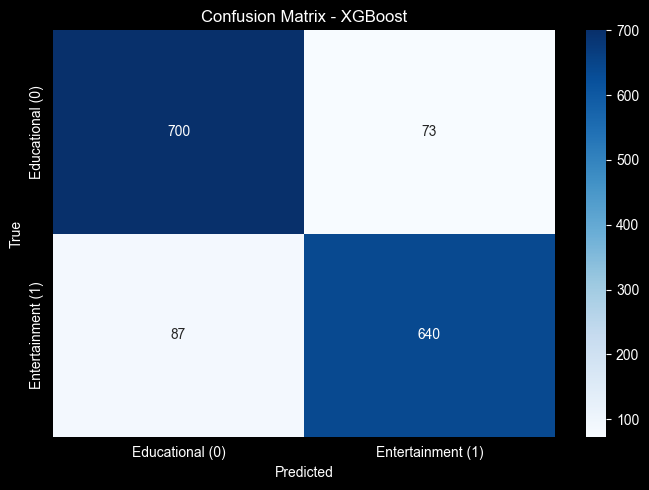

ROC-AUC (pos=Entertainment=1): 0.9649
PR-AUC / AP (pos=Entertainment=1): 0.9648
Threshold tuning (probability models):
  thr=0.30 -> precision=0.829, recall=0.944, f1=0.882
  thr=0.50 -> precision=0.898, recall=0.880, f1=0.889
  thr=0.70 -> precision=0.943, recall=0.780, f1=0.854

Done.


In [5]:
# Stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.3, random_state=42, stratify=y
)

models = {
    "Logistic Regression": {
        "model": LogisticRegression(),
        "params": {"C": [0.1, 1, 10], "solver": ["liblinear"]},
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {"n_estimators": [50, 100, 200], "max_depth": [None, 10, 20]},
    },
    "SVM": {
        "model": SVC(probability=True, random_state=42),
        "params": {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]},
    },
    "Ridge Classifier": {
        "model": RidgeClassifier(),
        "params": {"alpha": [0.1, 1, 10]},
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {"max_depth": [None, 5, 10, 20], "criterion": ["gini", "entropy"]},
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 0.2]},
    },
}

if HAS_XGB:
    models["XGBoost"] = {
        "model": XGBClassifier(eval_metric="logloss", random_state=42),
        "params": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 0.2], "max_depth": [3, 6, 9]},
    }

thresholds_to_test = [0.3, 0.5, 0.7]

def plot_confusion(cm, title):
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=LABELS, yticklabels=LABELS)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

def get_scores(model, X):
    # Positive class = 1 (Entertainment)
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    if hasattr(model, "decision_function"):
        return model.decision_function(X)
    return None

results = {}
best_models = {}
auc_results = {}
ap_results = {}

for name, cfg in models.items():
    print(f"\n=== Training model: {name} ===")
    clf = GridSearchCV(cfg["model"], cfg["params"], cv=5, scoring="accuracy", n_jobs=-1)
    clf.fit(X_train, y_train)

    best = clf.best_estimator_
    best_models[name] = best

    y_pred = best.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    print("Best params:", clf.best_params_)
    print(f"Accuracy: {acc:.4f} | Balanced Acc: {bal_acc:.4f} | MCC: {mcc:.4f}")
    print(classification_report(y_test, y_pred, target_names=LABELS, zero_division=0))

    cm = confusion_matrix(y_test, y_pred)
    plot_confusion(cm, f"Confusion Matrix - {name}")

    # ROC-AUC / PR-AUC require choosing a positive class by definition.
    # Convention here: Entertainment=1 (classes are otherwise equally important).
    y_score = get_scores(best, X_test)
    if y_score is not None:
        roc_auc = roc_auc_score(y_test, y_score)
        ap = average_precision_score(y_test, y_score)
        auc_results[name] = roc_auc
        ap_results[name] = ap
        print(f"ROC-AUC (pos=Entertainment=1): {roc_auc:.4f}")
        print(f"PR-AUC / AP (pos=Entertainment=1): {ap:.4f}")

        if hasattr(best, "predict_proba"):
            print("Threshold tuning (probability models):")
            for thr in thresholds_to_test:
                y_thr = (y_score >= thr).astype(int)
                rep = classification_report(y_test, y_thr, output_dict=True, zero_division=0)
                p = rep["1"]["precision"]
                r = rep["1"]["recall"]
                f1 = rep["1"]["f1-score"]
                print(f"  thr={thr:.2f} -> precision={p:.3f}, recall={r:.3f}, f1={f1:.3f}")

    results[name] = {
        "best_params": clf.best_params_,
        "accuracy": acc,
        "balanced_accuracy": bal_acc,
        "mcc": mcc,
        "roc_auc": auc_results.get(name, None),
        "ap": ap_results.get(name, None),
    }

print("\nDone.")


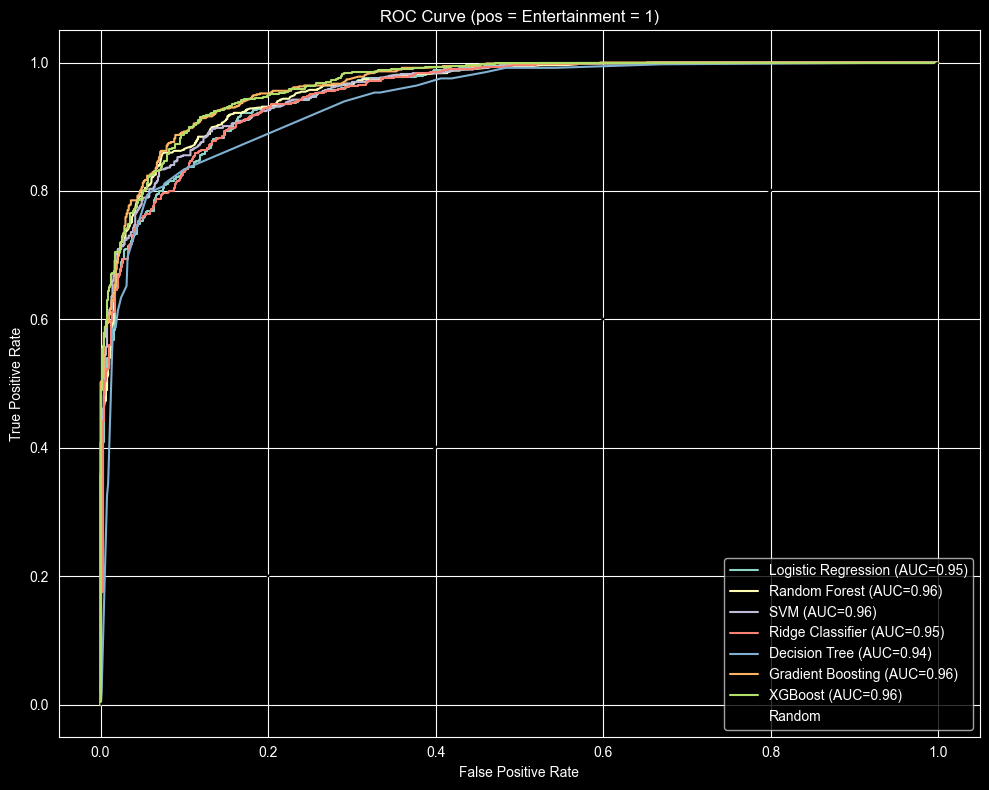

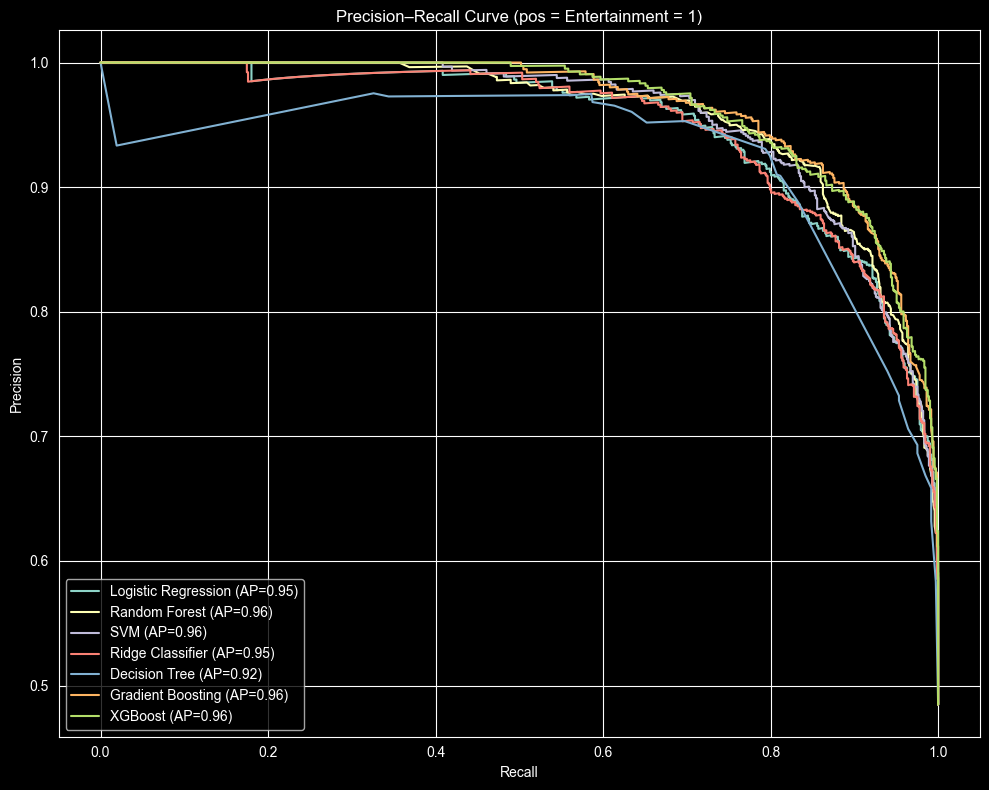

In [6]:
# ROC curves
plt.figure(figsize=(10, 8))
for name, model in best_models.items():
    y_score = get_scores(model, X_test)
    if y_score is None:
        continue
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = roc_auc_score(y_test, y_score)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (pos = Entertainment = 1)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Precision–Recall curves
plt.figure(figsize=(10, 8))
for name, model in best_models.items():
    y_score = get_scores(model, X_test)
    if y_score is None:
        continue
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    ap = average_precision_score(y_test, y_score)
    plt.plot(recall, precision, label=f"{name} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (pos = Entertainment = 1)")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()


In [7]:
# Summary table (sorted by ROC-AUC then Accuracy)
summary_df = pd.DataFrame(results).T.sort_values(by=["roc_auc", "accuracy"], ascending=False)
summary_df


,best_params,accuracy,balanced_accuracy,mcc,roc_auc,ap
XGBoost,"{'learning_rate': 0.2, 'max_depth': 3, 'n_esti...",0.893333,0.892946,0.786481,0.964907,0.964847
Gradient Boosting,"{'learning_rate': 0.1, 'n_estimators': 100}",0.896,0.895493,0.791916,0.964788,0.964596
Random Forest,"{'max_depth': 20, 'n_estimators': 200}",0.887333,0.886593,0.774833,0.957629,0.957254
SVM,"{'C': 1, 'kernel': 'rbf'}",0.875333,0.874786,0.750513,0.956195,0.956912
Logistic Regression,"{'C': 0.1, 'solver': 'liblinear'}",0.868,0.86763,0.735716,0.951741,0.949664
Ridge Classifier,{'alpha': 10},0.869333,0.869169,0.738402,0.951156,0.949401
Decision Tree,"{'criterion': 'gini', 'max_depth': 5}",0.868,0.866198,0.739332,0.938998,0.923114
